In [1]:
import pandas as pd
import numpy as np
import networkx as nx

### Building First Bi-Partite Graph

Note that we need to keep values titled "NA" because that's Namibia's ISO2 code. Also, Kosovo doesn't have an ISO3 so we can't use that.

In [3]:
subsidy = pd.read_csv('input/policy/Fossil_Fuel_Subsidies.csv', index_col=0, keep_default_na=False, na_values="")
subsidy.head(3)

,Country,ISO2,ISO3,Indicator,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,Unit,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022,F2023,F2024,F2025
ObjectId,,,,,,,,,,,,,,,,,,,,
1,"Afghanistan, Islamic Rep. of",AF,AFG,Explicit Fossil Fuel Subsidies - Coal,"Parry, Ian; Black, Simon; Vernon, Nate. Septem...",ECGFTEC,Explicit; Coal,"Environment, Climate Change, Government Policy...",Percent of GDP,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Afghanistan, Islamic Rep. of",AF,AFG,Explicit Fossil Fuel Subsidies - Coal,"Parry, Ian; Black, Simon; Vernon, Nate. Septem...",ECGFTEC,Explicit; Coal,"Environment, Climate Change, Government Policy...",US Dollars,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Afghanistan, Islamic Rep. of",AF,AFG,Explicit Fossil Fuel Subsidies - Electricity,"Parry, Ian; Black, Simon; Vernon, Nate. Septem...",ECGFTET,Explicit; Electricity,"Environment, Climate Change, Government Policy...",Percent of GDP,0.0,0.0,0.0,0.083287,0.375834,0.075661,0.252216,0.247982,0.270226,0.271118,0.245831


In [4]:
country_nodes = subsidy.ISO2.unique()
policy_nodes = subsidy.CTS_Code.unique()
print("Number of Countries:", len(country_nodes))
print("Number of Subsidies:", len(policy_nodes))

Number of Countries: 197
Number of Subsidies: 21


Another question would be how do we create groups of subsidies.

In [5]:
B = nx.Graph()
B.add_nodes_from(country_nodes, bipartite=0)
B.add_nodes_from(policy_nodes, bipartite=1)

Note that the following countries do not have the Petroleum field. We'll simply not draw edges.

In [6]:
full = set(subsidy[subsidy.ISO2 == "AF"].CTS_Name)
subsidy_sub = subsidy[subsidy.Unit == "Percent of GDP"]
for country in country_nodes:
    subset = subsidy_sub[subsidy_sub.ISO2 == country]
    if len(subset) < 21:
        print(country, len(subset))
        partial = set(subsidy[subsidy.ISO2 == country].CTS_Name)
        print(full - partial)

AI 20
{'Implicit; Petroleum'}
MH 20
{'Implicit; Petroleum'}
PW 20
{'Implicit; Petroleum'}
SM 20
{'Implicit; Petroleum'}
TV 20
{'Implicit; Petroleum'}


Loop through every country/policy combination and add an edge if the value for specified year was greater than 0.

In [7]:
df_temp = subsidy[subsidy.Unit == "Percent of GDP"]
df_temp.set_index(["ISO2", "CTS_Code"], inplace = True)
edge_list = []
year = "F2018"

for country in country_nodes:
    subset = df_temp.loc[country]
    for policy_code in subset.index:
        weight = subset.loc[policy_code][year]
        if weight > 0:
            edge = (country, policy_code, weight)
            edge_list.append(edge)

B.add_weighted_edges_from(edge_list)

In [8]:
print("Number of Edges:", B.number_of_edges())
print("Number of Possible Edges:", len(country_nodes) * len(policy_nodes))

Number of Edges: 2625
Number of Possible Edges: 4137


### Green Bonds Graph

In [94]:
green_bonds = pd.read_csv("input/policy/Green_Bonds.csv", index_col=0, keep_default_na=False, na_values="")

# Filtered Down to countries
green_bonds = green_bonds[np.logical_not(green_bonds["ISO2"].isna())]

green_bond_country_nodes = green_bonds.ISO2.unique()

# Need to figure out the differences between these bonds
bonds_nodes = green_bonds["CTS_Name"].unique()

Looks likes most years no one invested in bonds. Still very few countries invest in bonds but each year it seems the number increases.

In [95]:
import matplotlib.pyplot as plt

# Get the data
num_countries = green_bonds[green_bonds.columns[12:]].count().array()
years = [int(year[1:]) for year in green_bonds.index]

# Plot
fig,ax = plt.subplots()
ax.scatter(years, num_countries)
ax.set_title("Number of Countries using Green Bonds by year")
ax.set_ylabel("Number of Countries")
ax.set_xlabel("Year")

plt.show()

TypeError: 'PandasArray' object is not callable

Furthermore we can break the graph down into its two different categories

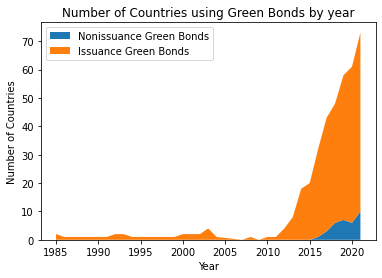

In [ ]:
import matplotlib.pyplot as plt

# Get the data
issuances = green_bonds[green_bonds["CTS_Name"] == "Green Bonds Issuances"]

# Calculate Variables
issuance_count = issuances[issuances.columns[12:]].count()
nonissuance_count = num_countries - issuance_count
y = np.vstack([nonissuance_count, issuance_count])

# Plot
fig,ax = plt.subplots()
# Using years var from last cell
ax.stackplot(years, y, labels = ["Nonissuance Green Bonds", "Issuance Green Bonds",])
ax.set_title("Number of Countries using Green Bonds by year")
ax.set_ylabel("Number of Countries")
ax.set_xlabel("Year")
ax.legend(loc = "upper left")

plt.show()

In [ ]:
Bonds = nx.Graph()
Bonds.add_nodes_from(green_bond_country_nodes, bipartite=0)
Bonds.add_nodes_from(bonds_nodes, bipartite=1)

In [ ]:
green_bonds_temp = green_bonds.set_index(["ISO2", "CTS_Name"], inplace = False)
green_bonds_temp
edge_list = []
year = "F2015"

for country in green_bond_country_nodes:
    subset = green_bonds_temp.loc[country]
    for bond in subset.index:
        weight = subset.loc[bond][year]
        if weight > 0:
            edge = (country, bond, weight)
            edge_list.append(edge)

Bonds.add_weighted_edges_from(edge_list)

### Environmental Taxes

First lets load in the data and take a quick peak.  The final table is a table about how many measures each country implements.

In [9]:
taxes = pd.read_csv("input/policy/Environmental_Taxes.csv")

num_countries = len(taxes["Country"].unique())
print(f"There are {num_countries} unique countries that are implementing environmental taxes")
print("Each country typically reports 10 different measures, but there are a few that report less than 10 measures")

taxes.Country.value_counts().value_counts()

There are 124 unique countries that are implementing environmental taxes
Each country typically reports 10 different measures, but there are a few that report less than 10 measures


10    118
8       3
6       1
5       1
4       1
Name: Country, dtype: int64

In [11]:
country_nodes = taxes.ISO2.unique()
policy_nodes = taxes.CTS_Code.unique()
print("Number of Countries:", len(country_nodes))
print("Number of Subsidies:", len(policy_nodes))

B = nx.Graph()
B.add_nodes_from(country_nodes, bipartite=0)
B.add_nodes_from(policy_nodes, bipartite=1)

Number of Countries: 124
Number of Subsidies: 5


In [ ]:
edges = []
year = "F2018"
taxes_sub = taxes[taxes.Unit == "Percent of GDP"]
for country in country_nodes:
    subset = taxes_sub[taxes_sub.ISO2 == country]
    for policy in policy_nodes:
        weight = subset[subset.CTS_Code == policy][year].values
        if weight > 0:
            edge = (country, policy, weight[0])
            edges.append(edge)

In [75]:
B.add_weighted_edges_from(edges)
print("Number of Edges:", B.number_of_edges())
print("Number of Possible Edges:", len(country_nodes) * len(policy_nodes))

Number of Edges: 415
Number of Possible Edges: 620


### Environmental Protection Expenditures

In [ ]:
expenditures = pd.read_csv("input/policy/Environmental_Protection_Expenditures.csv")
# testing

### Analysis

In [96]:
for comp in nx.connected_components(B):
    print(comp)

{'KH', 'BY', 'QA', 'HU', 'LC', 'GQ', 'ECGFTT', 'HR', 'SR', 'ZW', 'AE', 'ET', 'CD', 'LY', 'IQ', 'SS', 'ECGFTP', 'ECGFTI', 'BO', 'BA', 'RW', 'ECGFTIP', 'GA', 'ECGFTIF', 'NI', 'DO', 'SV', 'ID', 'ECGFT', 'RS', 'BT', 'PS', 'CN', 'UA', 'CR', 'DK', 'SC', 'TG', 'ECGFTEC', 'SY', 'NA', 'NR', 'MK', 'NL', 'IR', 'LU', 'DE', 'CM', 'WS', 'KI', 'DZ', 'CO', 'TO', 'LT', 'TZ', 'GT', 'XK', 'ECGFTET', 'ECGFTIR', 'ECGFTIL', 'CG', 'NE', 'PK', 'IS', 'BD', 'ECGFTEN', 'MY', 'TR', 'ZM', 'MX', 'SG', 'BB', 'KG', 'SE', 'LB', 'ECGFTE', 'CH', 'ML', 'KW', 'BF', 'GB', 'AW', 'MT', 'MZ', 'SO', 'MU', 'NG', 'ECGFTIN', 'AR', 'IL', 'MR', 'MO', 'TW', 'ECGFTIA', 'ECGFTIG', 'AG', 'TL', 'OM', 'IN', 'AF', 'ECGFTIC', 'KM', 'TN', 'IE', 'GY', 'JO', 'ECGFTIW', 'BR', 'MW', 'FM', 'NP', 'AU', 'BN', 'PE', 'TT', 'GD', 'ECGFTIT', 'GR', 'AT', 'AM', 'GE', 'FJ', 'MA', 'VC', 'ECGFTEP', 'BZ', 'CV', 'CF', 'BH', 'CZ', 'NZ', 'FI', 'RO', 'PA', 'MM', 'EG', 'FR', 'US', 'MN', 'LK', 'PT', 'TM', 'SI', 'VN', 'BE', 'VU', 'PL', 'CI', 'PH', 'MG', 'YE', 'RU'